In [22]:
import sys, os
from itertools import chain

HOME_PATH = '/home/vvieira'
sys.path.extend([os.path.join(HOME_PATH,pkg,'src') for pkg in ('cobamp','troppo','human_ts_models/shared')])
os.chdir(os.path.join(HOME_PATH,'human_ts_models'))

import re
import pandas as pd
import numpy as np
import cobra
import matplotlib.pyplot as plt
import seaborn as sns

from cobra.io import read_sbml_model

cobra.Configuration.solver = cobra.util.solvers['cplex']

from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from cobamp.core.optimization import BatchOptimizer
from cobamp.utilities.file_io import pickle_object, read_pickle
from cobamp.utilities.parallel import MP_THREADS
from cobamp.wrappers.external_wrappers import get_model_reader
from troppo.omics.core import IdentifierMapping, TypedOmicsMeasurementSet

from numpy import abs as npabs

from models import get_human1_model

ROOT_FOLDER = 'projects/breast_mcf7'
MODEL_DF_NAME = 'cs_models_all_combinations'
CS_MODEL_DF_FOLDER = os.path.join(ROOT_FOLDER, 'results/human1/reconstructions/mcf7_comparison')
MODEL_DF_PATH = os.path.join(CS_MODEL_DF_FOLDER,MODEL_DF_NAME+'.csv')
MODEL_DF_PATH_BIOMASS_GAPFILL = os.path.join(CS_MODEL_DF_FOLDER,MODEL_DF_NAME+'_biomass.csv')
MODEL_DF_PATH_FULL_GAPFILL = os.path.join(CS_MODEL_DF_FOLDER,MODEL_DF_NAME+'biomass_media.csv')
MODEL_DF_FULL_GAPFILL_MEDIA = os.path.join(CS_MODEL_DF_FOLDER,MODEL_DF_NAME+'media_reactions.json')
ACHILLES_PATH = 'projects/breast_mcf7/data/ccle/DepMap Public 20Q1/Achilles_gene_effect.csv'
ORIGINAL_MEDIA_PATH = os.path.join(CS_MODEL_DF_FOLDER,MODEL_DF_NAME+'original_media.txt')

BOF_ESS_FOLDER = os.path.join(CS_MODEL_DF_FOLDER,'essentiality')
BOF_ESS_PATH = os.path.join(BOF_ESS_FOLDER,MODEL_DF_NAME+'_bof_essentiality.pkl')
BOF_PAR_ESS_PATH = os.path.join(BOF_ESS_FOLDER,MODEL_DF_NAME+'_bof_essentiality_params.pkl')
MODEL_PATH = 'projects/breast_mcf7/support/Human-GEM.xml'
NTHREADS = 12

In [2]:
model = read_sbml_model('shared/models/Human-GEM_latest_consistent.xml')
cobamp_model = get_model_reader(model, ttg_ratio=100000).to_cobamp_cbm('CPLEX')
model_genes = cobamp_model.gpr.get_genes()

model_df = pd.read_csv(MODEL_DF_PATH_BIOMASS_GAPFILL, index_col=[0, 1, 2])

from cobamp.utilities.file_io import read_pickle
baseline = read_pickle('projects/breast_mcf7/data/human1_gems/a.pkl')

model_df = model_df.append(pd.Series(model_df.columns.isin(baseline), index=model_df.columns,
                        name=('tinit_baseline', None, None, None)))

In [5]:
ach_df = pd.read_csv(ACHILLES_PATH, index_col=0)

hgnc_df = pd.read_csv('ftp://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/non_alt_loci_set.txt',
                      index_col=0, sep='\t')
hgnc_df['entrez_id'] = [str(int(x)) if not np.isnan(x) else np.nan for x in hgnc_df['entrez_id']]

mapping = IdentifierMapping('human_transcriptomics', hgnc_df)

ach_mset = TypedOmicsMeasurementSet(ach_df.index, ach_df.columns, ach_df.values, mapping)
ensembl_patt = re.compile('\([0-9]*\)')

ach_mset.column_names = [str(ensembl_patt.findall(k)[0].replace('(', '').replace(')', '')) for k in
                         ach_mset.column_names]
conv_dict = mapping.get_id_table(ach_mset.column_names, 'entrez_id').set_index('entrez_id')['ensembl_gene_id'].to_dict()

ach_mset.column_names = [conv_dict[k] if k in conv_dict else np.nan for k in ach_mset.column_names]
ach_mset.drop(columns=ach_mset.data.columns[~ach_mset.data.columns.isin(model_genes)])
ach_mset.transform(lambda x: x.fillna(0))

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063 DtypeWarning: Columns (32,34,38,40,50) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
def get_state_dict_from_ko(ko):
    d = {k: True for k in cobamp_model.gpr.get_genes()}
    for k in ko:
        d[k] = False
    return d


state_dicts = {gko: get_state_dict_from_ko([gko]) for gko in model_genes}
reaction_states = {gko: {i: j for i, j in {k: cobamp_model.gpr.eval_gpr(ind, state_dicts[gko])
                                           for ind, k in enumerate(cobamp_model.reaction_names)}.items() if not j}
                   for gko in state_dicts.keys()}

reaction_states_inactive = {k: tuple(frozenset({i for i, j in v.items() if j is not None})) for k, v in
                            reaction_states.items()}

rko_sets = {}
for k, v in reaction_states_inactive.items():
    if v not in rko_sets.keys():
        rko_sets[v] = {k}
    else:
        rko_sets[v] |= {k}

kos_to_test = [l for l in list(rko_sets.keys()) if len(l) > 0]

In [5]:
def batch_ko_optimize(model, kos, context, objective, objective_sense, threads, override_bounds=None, ppreturn=True):
    with model as m:
        for crx, truth in context.items():
            if not truth: m.set_reaction_bounds(crx, lb=0, ub=0)
        if override_bounds is not None:
            print('\toverriding bounds...')
            for k, v in override_bounds.items():
                if k in m.reaction_names:
                    m.set_reaction_bounds(k, lb=v[0], ub=v[1])


        sol = m.optimize(objective, objective_sense)
        ofv = sol.objective_value()
        if sol.status() == 'optimal' and ofv > 0:
            gko_to_rko = [{m.decode_index(rko, 'reaction'): (0, 0) for rko in ko_set} for ko_set in kos]

            bopt = BatchOptimizer(m.model, threads=min(len(gko_to_rko), threads, MP_THREADS))

            opt_result = bopt.batch_optimize(gko_to_rko,
                                             [{m.decode_index(rko, 'reaction'): v for rko, v in
                                               objective.items()}] * len(gko_to_rko),
                                             [objective_sense] * len(gko_to_rko))

            return [k.objective_value() / ofv if (k.status() == 'optimal') and ofv > 0 else 0 for k in
                    opt_result] if ppreturn else opt_result
        else:
            print('\tModel objective is 0... skipping')
            return []

In [30]:
model_dicts = model_df.T.to_dict()

from json import JSONDecoder

with open(MODEL_DF_FULL_GAPFILL_MEDIA, 'r') as f:
    model_dict_media = dict([(tuple(i),k) for i,k in JSONDecoder().decode(f.read())])

if not os.path.exists(BOF_ESS_PATH):
    corr_coef_dict = {}
    for mkey, mdict in model_dicts.items():
        def process_results(bkopt):
            opt_res = dict(zip(kos_to_test, bkopt))
            of_res = {k: opt_res[v] if v in opt_res.keys() else 1 for k, v in reaction_states_inactive.items()}
            ddf = ach_mset.data.reindex(index=['ACH-000019'], columns=of_res).append(pd.Series(of_res, name='biomass')).T
            return matthews_corrcoef((ddf['biomass'] < 0.01), (ddf['ACH-000019'] < -0.6)), ddf

        print(mkey)
        context_dict = {k: v for k, v in mdict.items()}
        #context_dict.update({r.id: True for r in model.boundary})
        bkopt = batch_ko_optimize(model=cobamp_model, kos=kos_to_test, context=context_dict,
                                  objective={'biomass_human': 1}, objective_sense=False, threads=12)
        res = process_results(bkopt)
        corr_coef_dict[tuple(list(mkey)+['no_media'])] = res
        print('\t without media:', res[0])

        if mkey in model_dict_media:
            exchanges = set(chain(*cobamp_model.get_boundary_reactions().values()))
            media_list = set([k.split('_flux_backwards')[0] for k in model_dict_media[mkey]])
            bound_override = {k:(0, 1000) for k in exchanges
                              - media_list - {'HMR_10024', 'HMR_10023', 'biomass_human'}}
            bound_override.update({k:(-1000, 1000) for k in media_list})

            bkopt_media = batch_ko_optimize(model=cobamp_model, kos=kos_to_test, context=context_dict,
                                            override_bounds=bound_override, objective={'biomass_human': 1},
                                            objective_sense=False, threads=12)
            res_med = process_results(bkopt_media)
            corr_coef_dict[tuple(list(mkey)+['media_gapfill'])] = res_med
            print('\t with media:', res_med[0])

    pickle_object(corr_coef_dict, BOF_ESS_PATH)

In [193]:
pretty_names = {'tinit': 'INIT', 
                'fastcore': 'FASTCORE',
                'tinit_baseline': 'tINIT (Robinson et. al)',
                'global': 'Global', 
                'local1': 'Local 1-state',
                'local2': 'Local 2-state',
                'no_media': 'Default',
                'media_gapfill': 'Medium gapfill',
                'minsum': 'Minimum/Sum',
                'minmax': 'Minimum/Maximum',
                'nan': '-',
                'algorithm': 'Reconstruction algorithm',
                'media_bounds': 'Medium constraints',
               'thres_strat': 'Thresholding strategy',
               'g_min': 'Lower global threshold',
               'g_max': 'Upper global threshold',
               'local': 'Local threshold',
               'intfunc': 'Integration functions',
               'media_gapfill': 'Gapfilling method',
               'achilles_threshold': 'CERES essentiality threshold',
               'biomass_threshold': 'Relative growth rate threshold',
               'bounded': 'Bounded',
               'unbounded': 'Unbounded',
               'value_mean': 'Mean value',
               'value_sd': 'Standard deviation',
               'mcc': "Matthews' correlation coefficient",
               'base_model': "Template model"}

In [121]:
corr_coef_dict = read_pickle(BOF_ESS_PATH)
from sklearn.metrics import confusion_matrix

corr_coef_params = {}
for k, tup in corr_coef_dict.items():
    for i,lv in enumerate([-1.5, -1.25, -1.0, -0.75, -0.5]):
        for j,bv in enumerate([0.001,0.5,0.9,0.999]):
            y_true, y_pred = tup[1]['ACH-000019'] < lv, tup[1]['biomass'] < bv
            cfmatdict = dict(zip(['TN','FP','FN','TP'],
                             confusion_matrix(y_true, y_pred).ravel()))
            cfmatdict.update({'mcc':matthews_corrcoef(y_true, y_pred)})
            corr_coef_params[tuple(list(k)+[lv, bv])] = cfmatdict
            
corr_coef_df = pd.DataFrame(corr_coef_params).T
new_inds = [tuple([k[0]]+(k[1].split('_') if isinstance(k[1],str) else ['nan']*4)+list(k[2:])) 
                      for k in corr_coef_df.index]
corr_coef_df.index = pd.MultiIndex.from_tuples(new_inds, 
                                   names=['algorithm','thres_strat','g_min','g_max','local',
                                          'intfunc','media_gapfill','achilles_threshold','biomass_threshold'])

In [128]:
str_to_rep = dict(zip(['0','1','2','3','4'],[0.1, 0.25, 0.5, 0.75, 0.9]))
str_to_rep.update({k+'.0':v for k,v in str_to_rep.items()})

id_labels = corr_coef_df.index.names
molten_corr_coef_df = corr_coef_df.reset_index().fillna('nan').replace(str_to_rep)

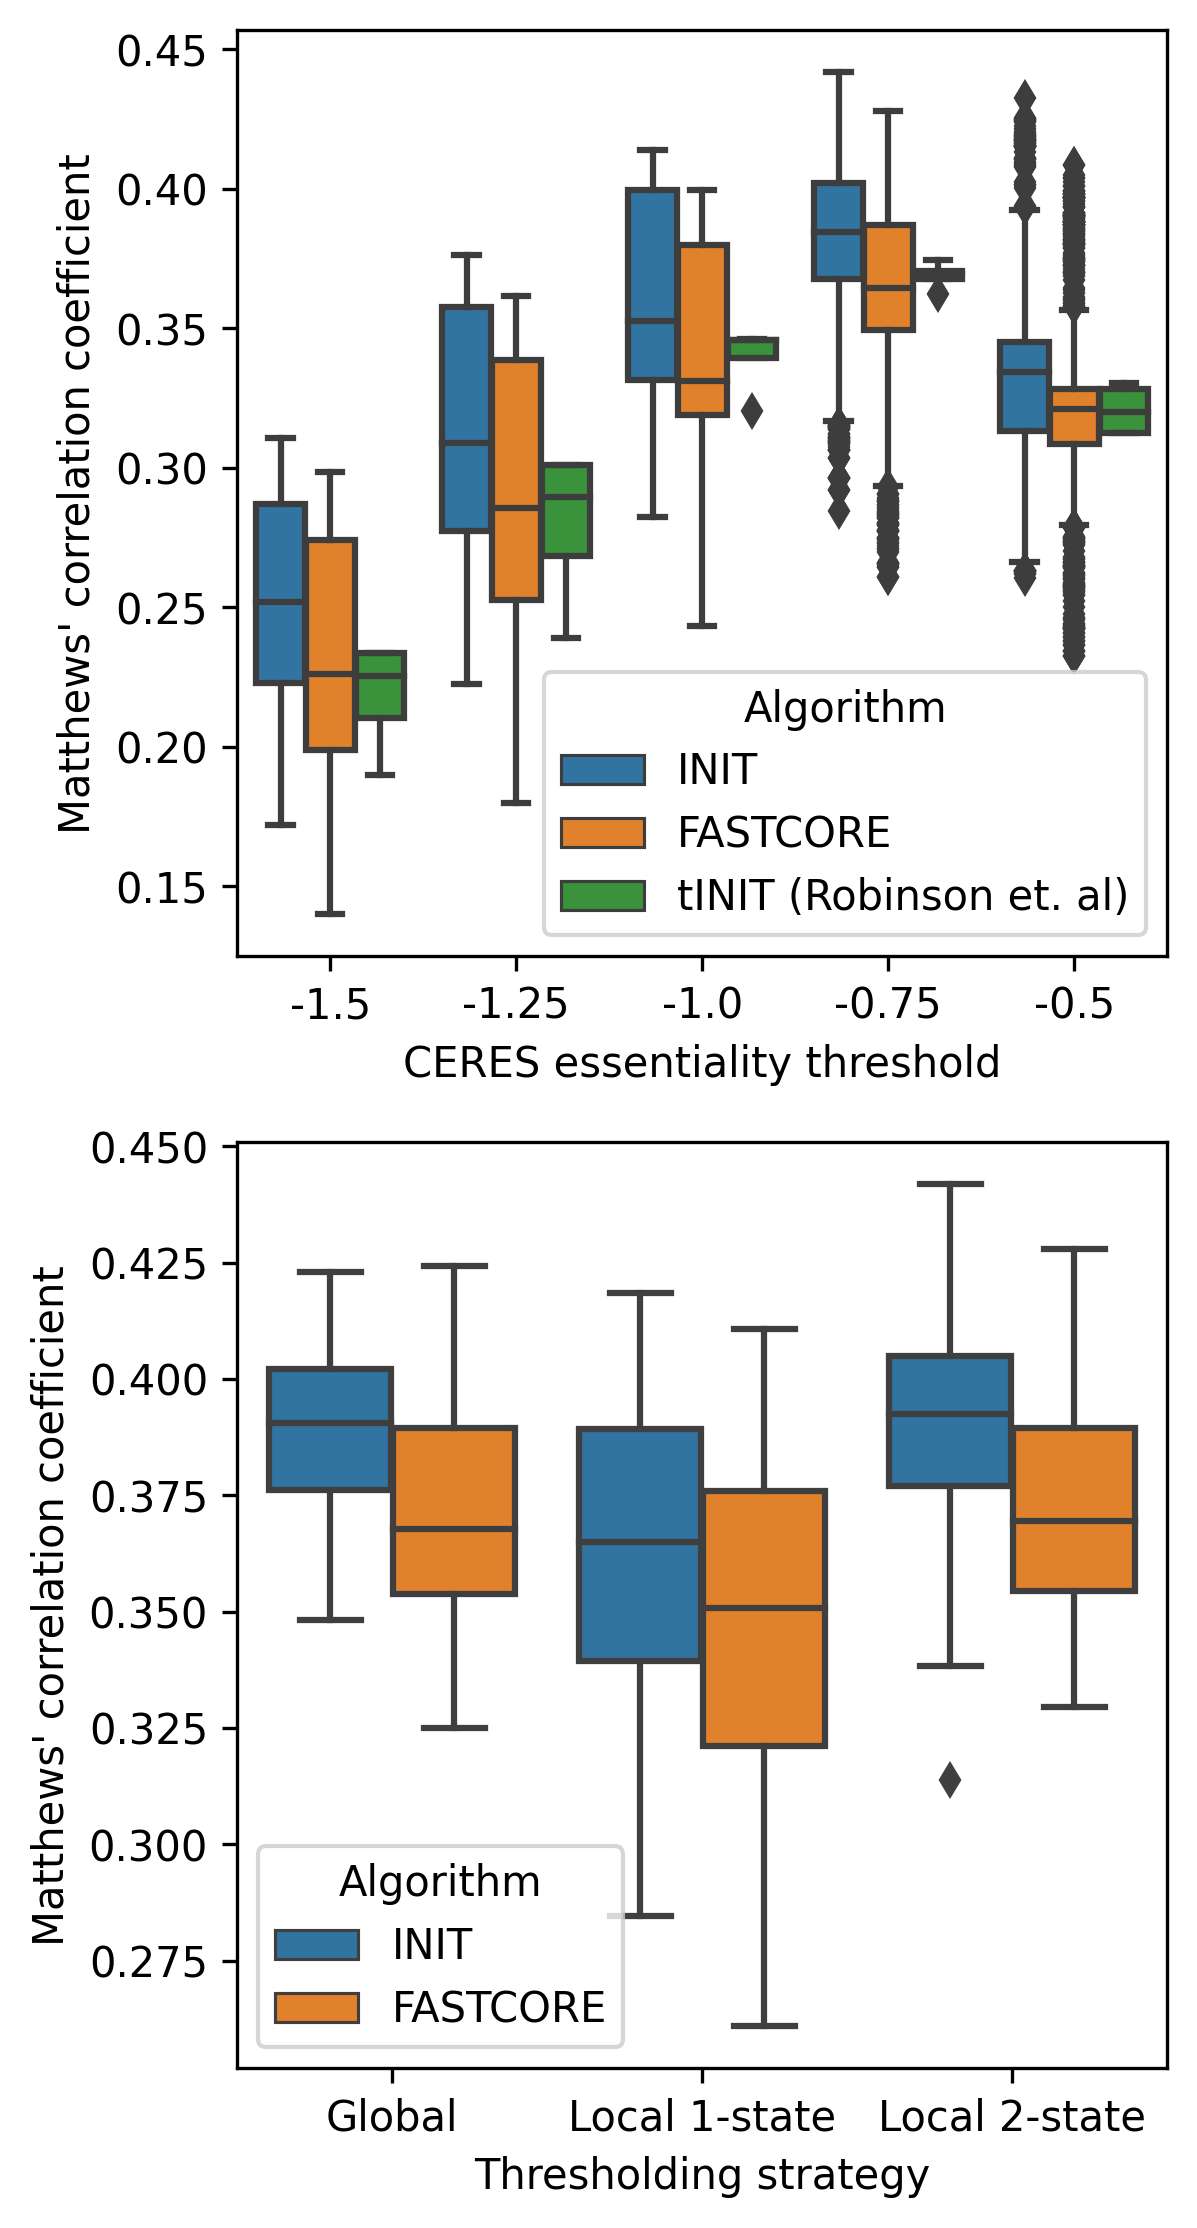

In [180]:
fig, axs = plt.subplots(2, 1, figsize=(4,9), dpi=300)

g1 = sns.boxplot(data=corr_coef_df.reset_index().replace(pretty_names),
                x="achilles_threshold", y="mcc", hue="algorithm", ax=axs[0])
g1.set_xlabel(pretty_names['achilles_threshold'])
g1.set_ylabel("Matthews' correlation coefficient")
axs[0].legend(title='Algorithm')

g2_data = molten_corr_coef_df.query('achilles_threshold == -0.75 & algorithm != "tinit_baseline"')\
            .replace(pretty_names).rename(pretty_names)

g2 = sns.boxplot(data=g2_data, 
                x="thres_strat", y="mcc", hue="algorithm", ax=axs[1])

g2.set_xlabel(pretty_names['thres_strat'])
g2.set_ylabel("Matthews' correlation coefficient")
axs[1].legend(title='Algorithm')

plt.savefig('projects/breast_mcf7/notebooks/mcf7_params_ge_upper.pdf')

In [176]:

data_orig = molten_corr_coef_df.query(
    'algorithm != "tinit_baseline" & achilles_threshold == -0.75')
y = molten_corr_coef_df['mcc']

clf_data_orig = data_orig.drop(columns=['mcc','TP','TN','FP','FN']).astype(str)
clf_data_orig = clf_data_orig.rename(columns=pretty_names).replace(pretty_names)

clf = Pipeline([('encode', OneHotEncoder()), ('lr', LinearRegression())])
clf.fit(clf_data_orig, data_orig['mcc'])

lreg = clf.steps[-1][1]

feature_names = [clf_data_orig.columns[int(i[0][1])] + ' = ' + '_'.join(i[1:]) 
 for i in [k.split('_') for k in clf.steps[-2][1].get_feature_names()]]

from numpy import abs as npabs

var_importance = pd.DataFrame({'Parameter value': feature_names, 'Coefficient': lreg.coef_, 'abs_importance': npabs(lreg.coef_)})\
                    .sort_values(by='Coefficient')
pvs = var_importance['Parameter value']
var_importance['Parameter value'] = pvs.apply(lambda x: 'No '+x.split(' = ')[0] if x.endswith('-') else x)

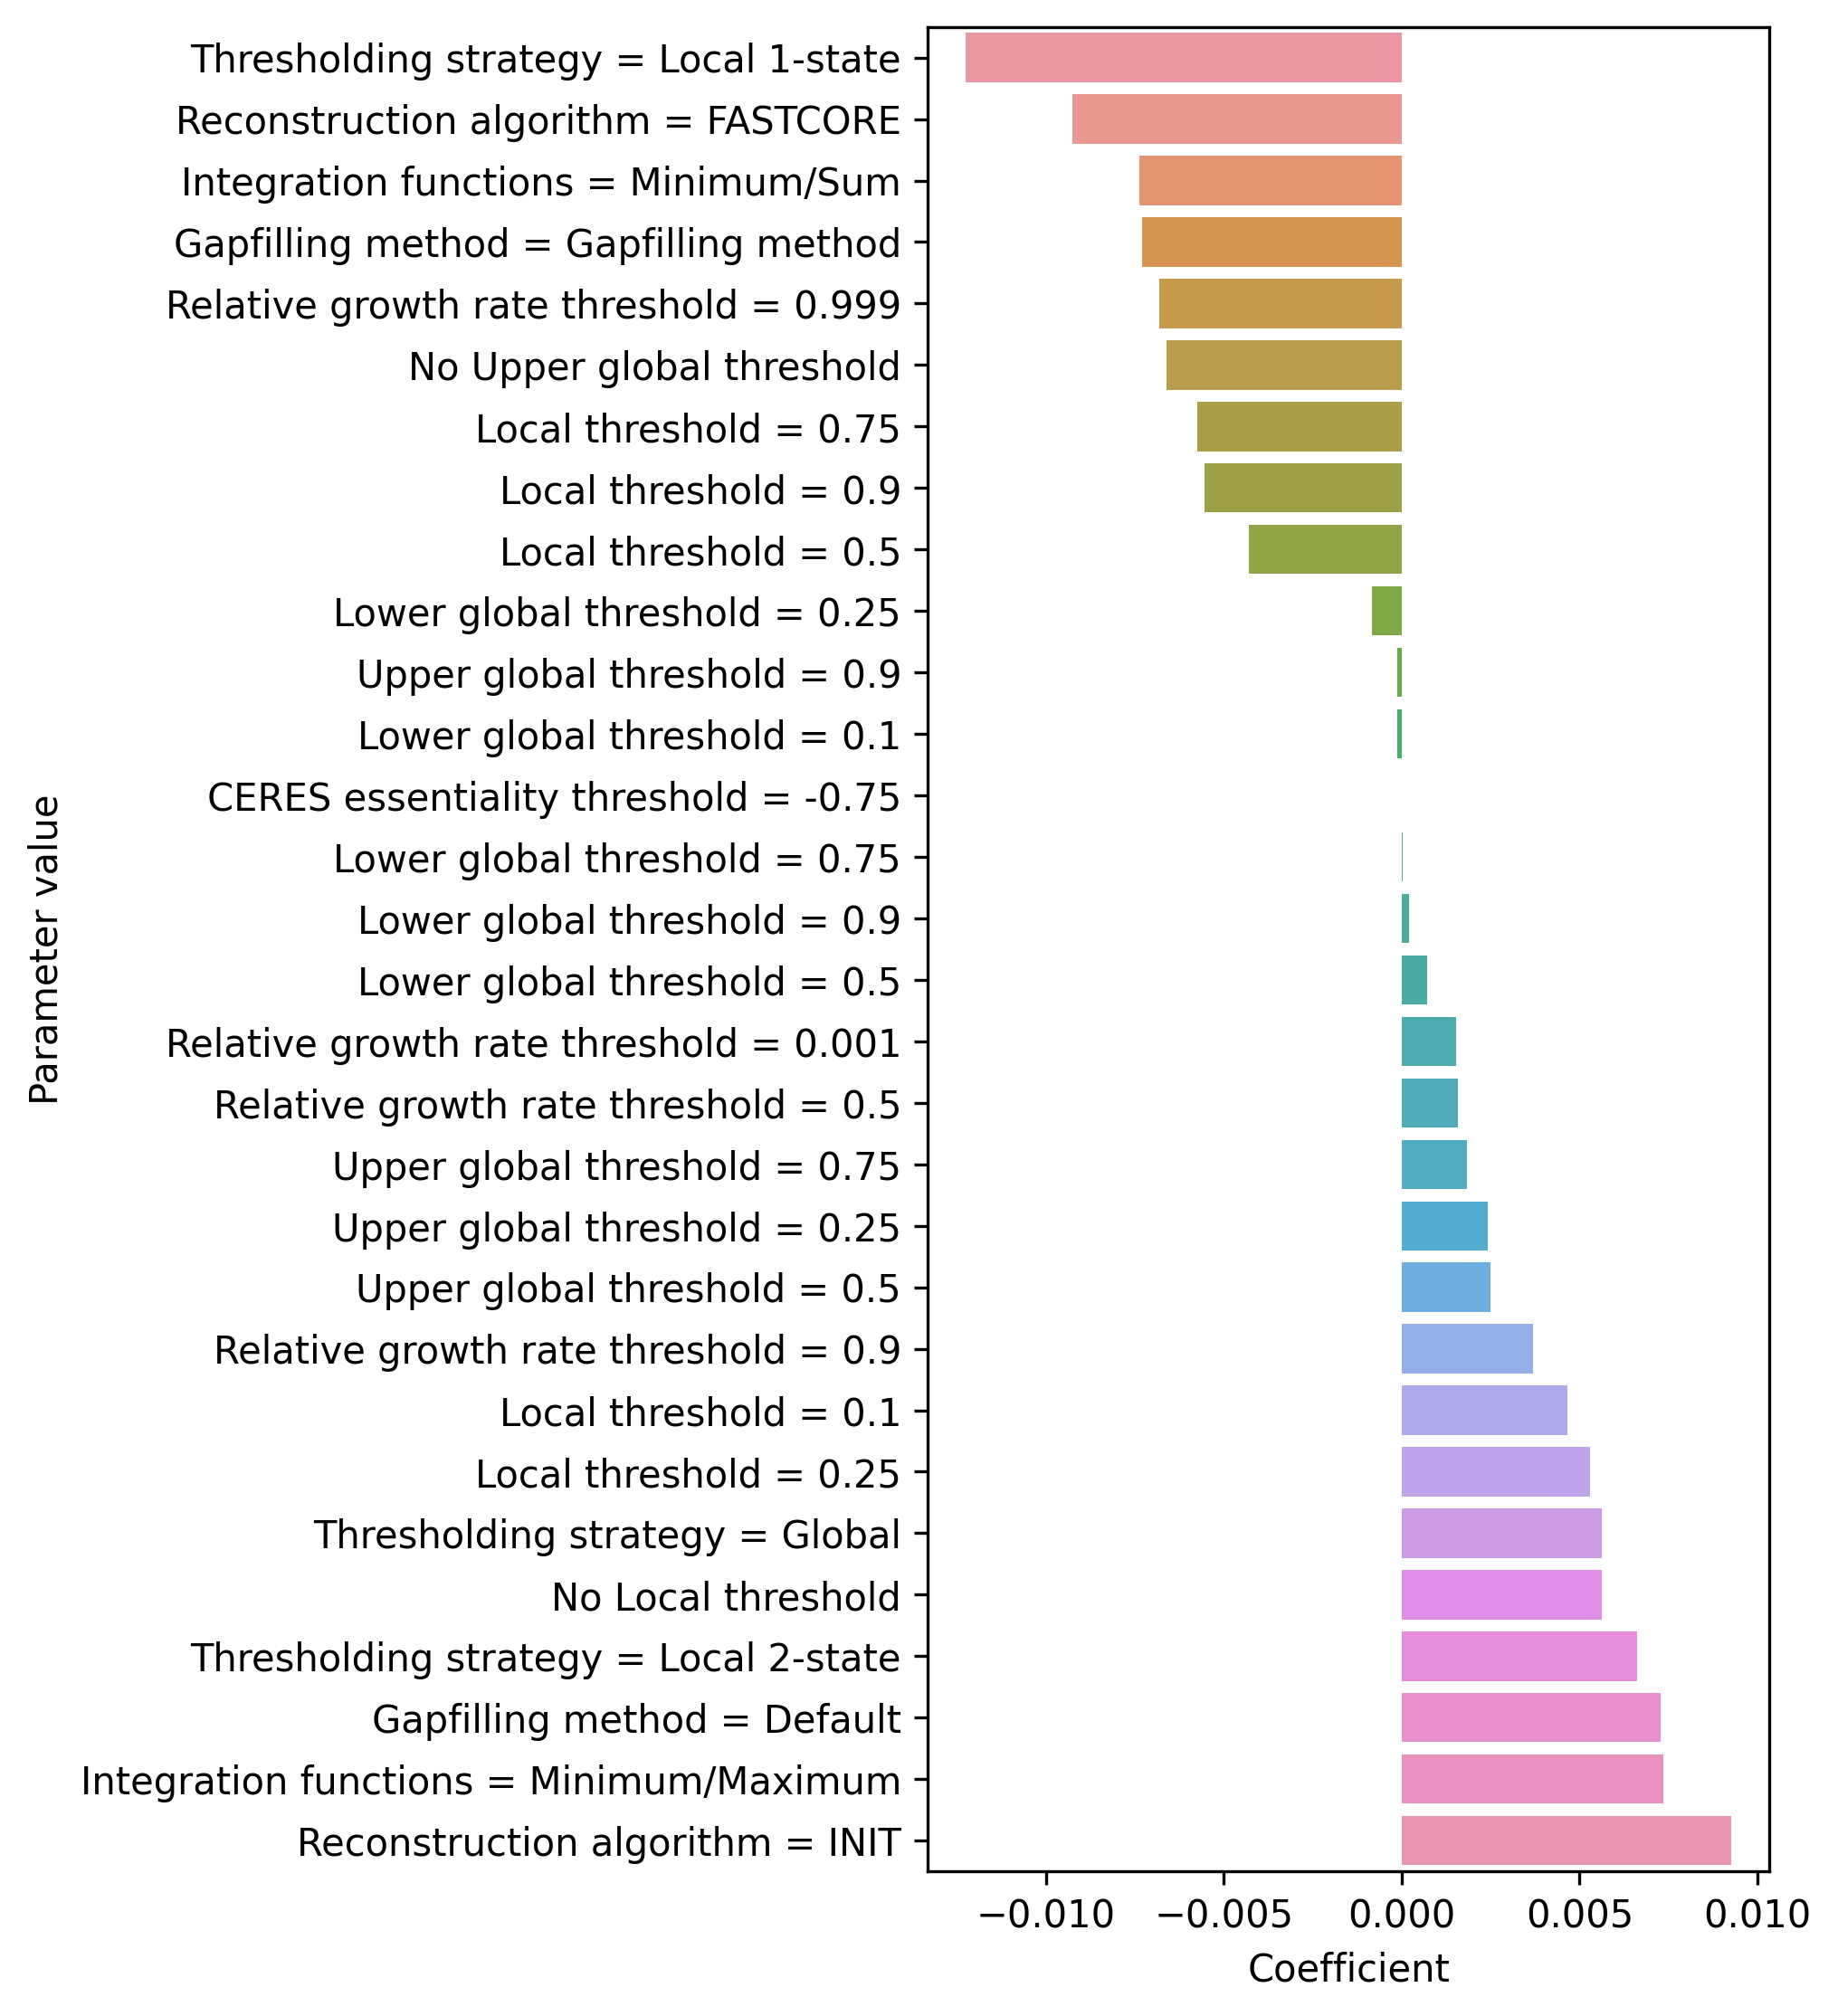

In [181]:
fig = plt.figure()
g = sns.barplot(data=var_importance, x='Coefficient', y='Parameter value')
fig.set_size_inches(4, 9)
fig.set_dpi(300)
plt.savefig('projects/breast_mcf7/notebooks/mcf7_params_ge_lower.pdf')

In [182]:
new_inds_model_md = [tuple([k[0]]+(k[1].split('_') if isinstance(k[1],str) else ['nan']*4)+list(k[2:])) 
                      for k in model_df.index]
                     
model_df_new = model_df.copy()
model_df_new.index = pd.MultiIndex.from_tuples(new_inds_model_md, 
                                   names=['algorithm','thres_strat','g_min','g_max','local','intfunc'])
model_df_new = model_df_new.fillna('nan')
model_df_md = model_df_new.reset_index().drop(columns=model_df.columns)
model_df_md.index = model_df.index

In [183]:
molten_corr_coef_df.sort_values('mcc', ascending=False).iloc[:5,:]

,algorithm,thres_strat,g_min,g_max,local,intfunc,media_gapfill,achilles_threshold,biomass_threshold,TN,FP,FN,TP,mcc
5315,tinit,local2,0.1,0.75,0.5,minmax,media_gapfill,-0.75,0.999,2666.0,108.0,154.0,124.0,0.441997
2154,tinit,local2,0.1,0.9,0.5,minsum,media_gapfill,-0.75,0.900,2667.0,107.0,155.0,123.0,0.440229
5594,tinit,local2,0.75,0.9,0.5,minmax,media_gapfill,-0.75,0.900,2664.0,110.0,154.0,124.0,0.439480
4595,tinit,local2,0.25,0.5,0.1,minmax,media_gapfill,-0.75,0.999,2640.0,134.0,145.0,133.0,0.438015
4635,tinit,local2,0.25,0.75,0.1,minmax,media_gapfill,-0.75,0.999,2628.0,146.0,142.0,136.0,0.433783


In [184]:
results = read_pickle(os.path.join(CS_MODEL_DF_FOLDER,MODEL_DF_NAME+'_simulation_dicts.pkl'))
flux_data = pd.read_csv('projects/breast_mcf7/data/katzir2019/fluxes.csvfixed_names.csv', index_col=0)

def get_sign(df): return (df/df.abs()).fillna(0)
def correct_fluxes(y_true, y_pred): return (y_true == y_pred).sum()/len(y_true)

flux_data_sign = get_sign(flux_data)

sign_agreement = {}
for tested_model, result_df in results.items():
    sim, sim_bound = result_df
    mcc_ub = {tuple((list(tested_model)+[name,'unbounded','mcc'])):matthews_corrcoef(flux_data_sign.loc[name,:], series) 
                for name, series in get_sign(sim.fillna(0)).iterrows()}
    if sim_bound is not None:
        mcc_ub.update({tuple((list(tested_model)+[name,'bounded','mcc'])):matthews_corrcoef(flux_data_sign.loc[name,:], series) 
                for name, series in list(get_sign(sim_bound.fillna(0)).iterrows())})
    sign_agreement.update(mcc_ub)

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars


In [194]:
sign_agreement_df = pd.DataFrame.from_dict(sign_agreement, orient='index')
sign_agreement_df.index = pd.MultiIndex.from_tuples(sign_agreement_df.index,
                                                   names=['algorithm','params','intfunc','condition','media','variable'])

sag_new_inds = [tuple([k[0]]+(k[1].split('_') if isinstance(k[1],str) else ['nan']*4)+list(k[2:])) for k in sign_agreement_df.index]
ftnames = ['algorithm','thres_strat','g_min','g_max','local','intfunc','exp_condition','media_bounds','metric']
sign_agreement_df.index = pd.MultiIndex.from_tuples(sag_new_inds, names=ftnames)
sign_agreement_df.columns=['value']
sign_agreement_df = sign_agreement_df.reset_index().fillna('nan').replace(str_to_rep)

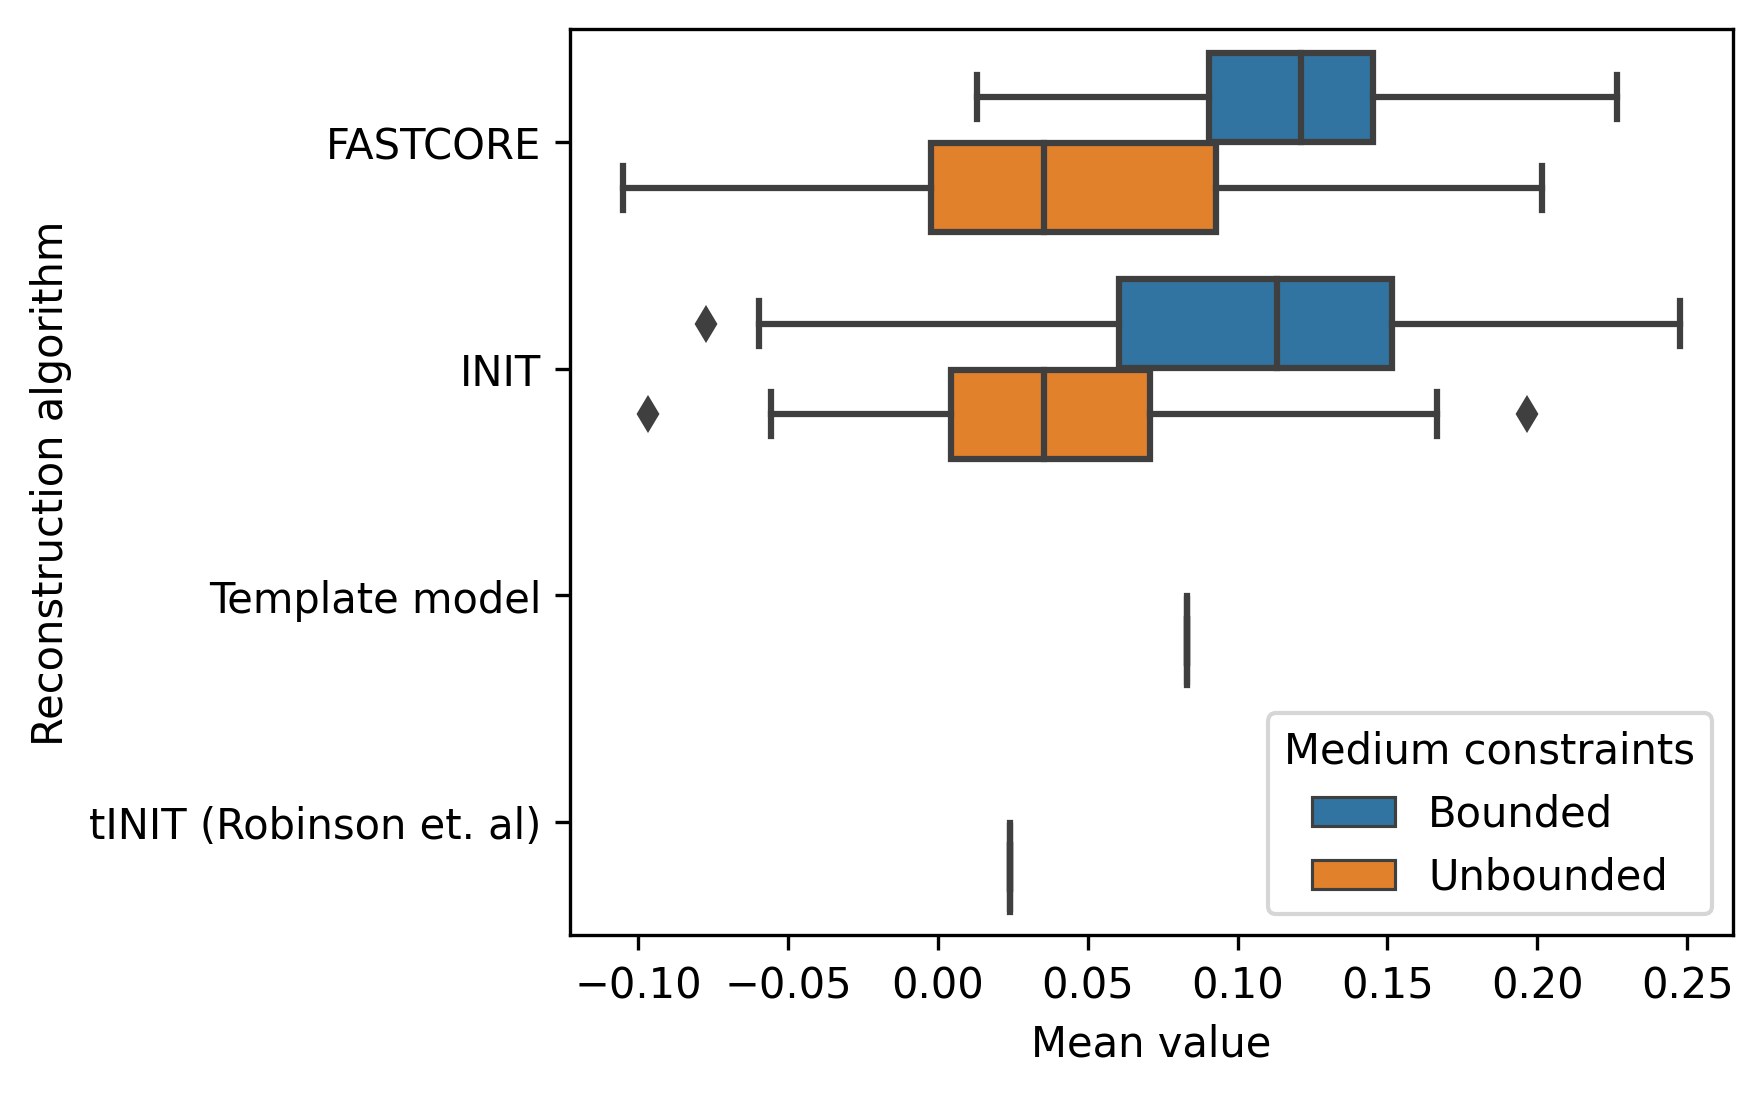

In [211]:
import seaborn as sns
agg_funx = {'mean':lambda x: x.mean(), 'sd': lambda x: x.std()}
sign_agreement_mean_df = sign_agreement_df.groupby(list(set(ftnames) - {'exp_condition'}))\
                        .agg(list(agg_funx.items())).reset_index()

sign_agreement_mean_df.columns = map(lambda x: '_'.join(x) if x[1] != '' else x[0], sign_agreement_mean_df.columns)

g = sns.boxplot(data=sign_agreement_mean_df.rename(columns=pretty_names).replace(pretty_names), 
            hue=pretty_names['media_bounds'],x=pretty_names['value_mean'],y=pretty_names['algorithm'])
g.figure.set_dpi(300)
g.figure.set_size_inches(5,4)

plt.savefig('projects/breast_mcf7/notebooks/mcf7_params_flux_boxplot.pdf')

<AxesSubplot:xlabel='Mean value', ylabel='Standard deviation'>

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/seaborn/distributions.py:306 UserWarning: Dataset has 0 variance; skipping density estimate.
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/seaborn/distributions.py:306 UserWarning: Dataset has 0 variance; skipping density estimate.


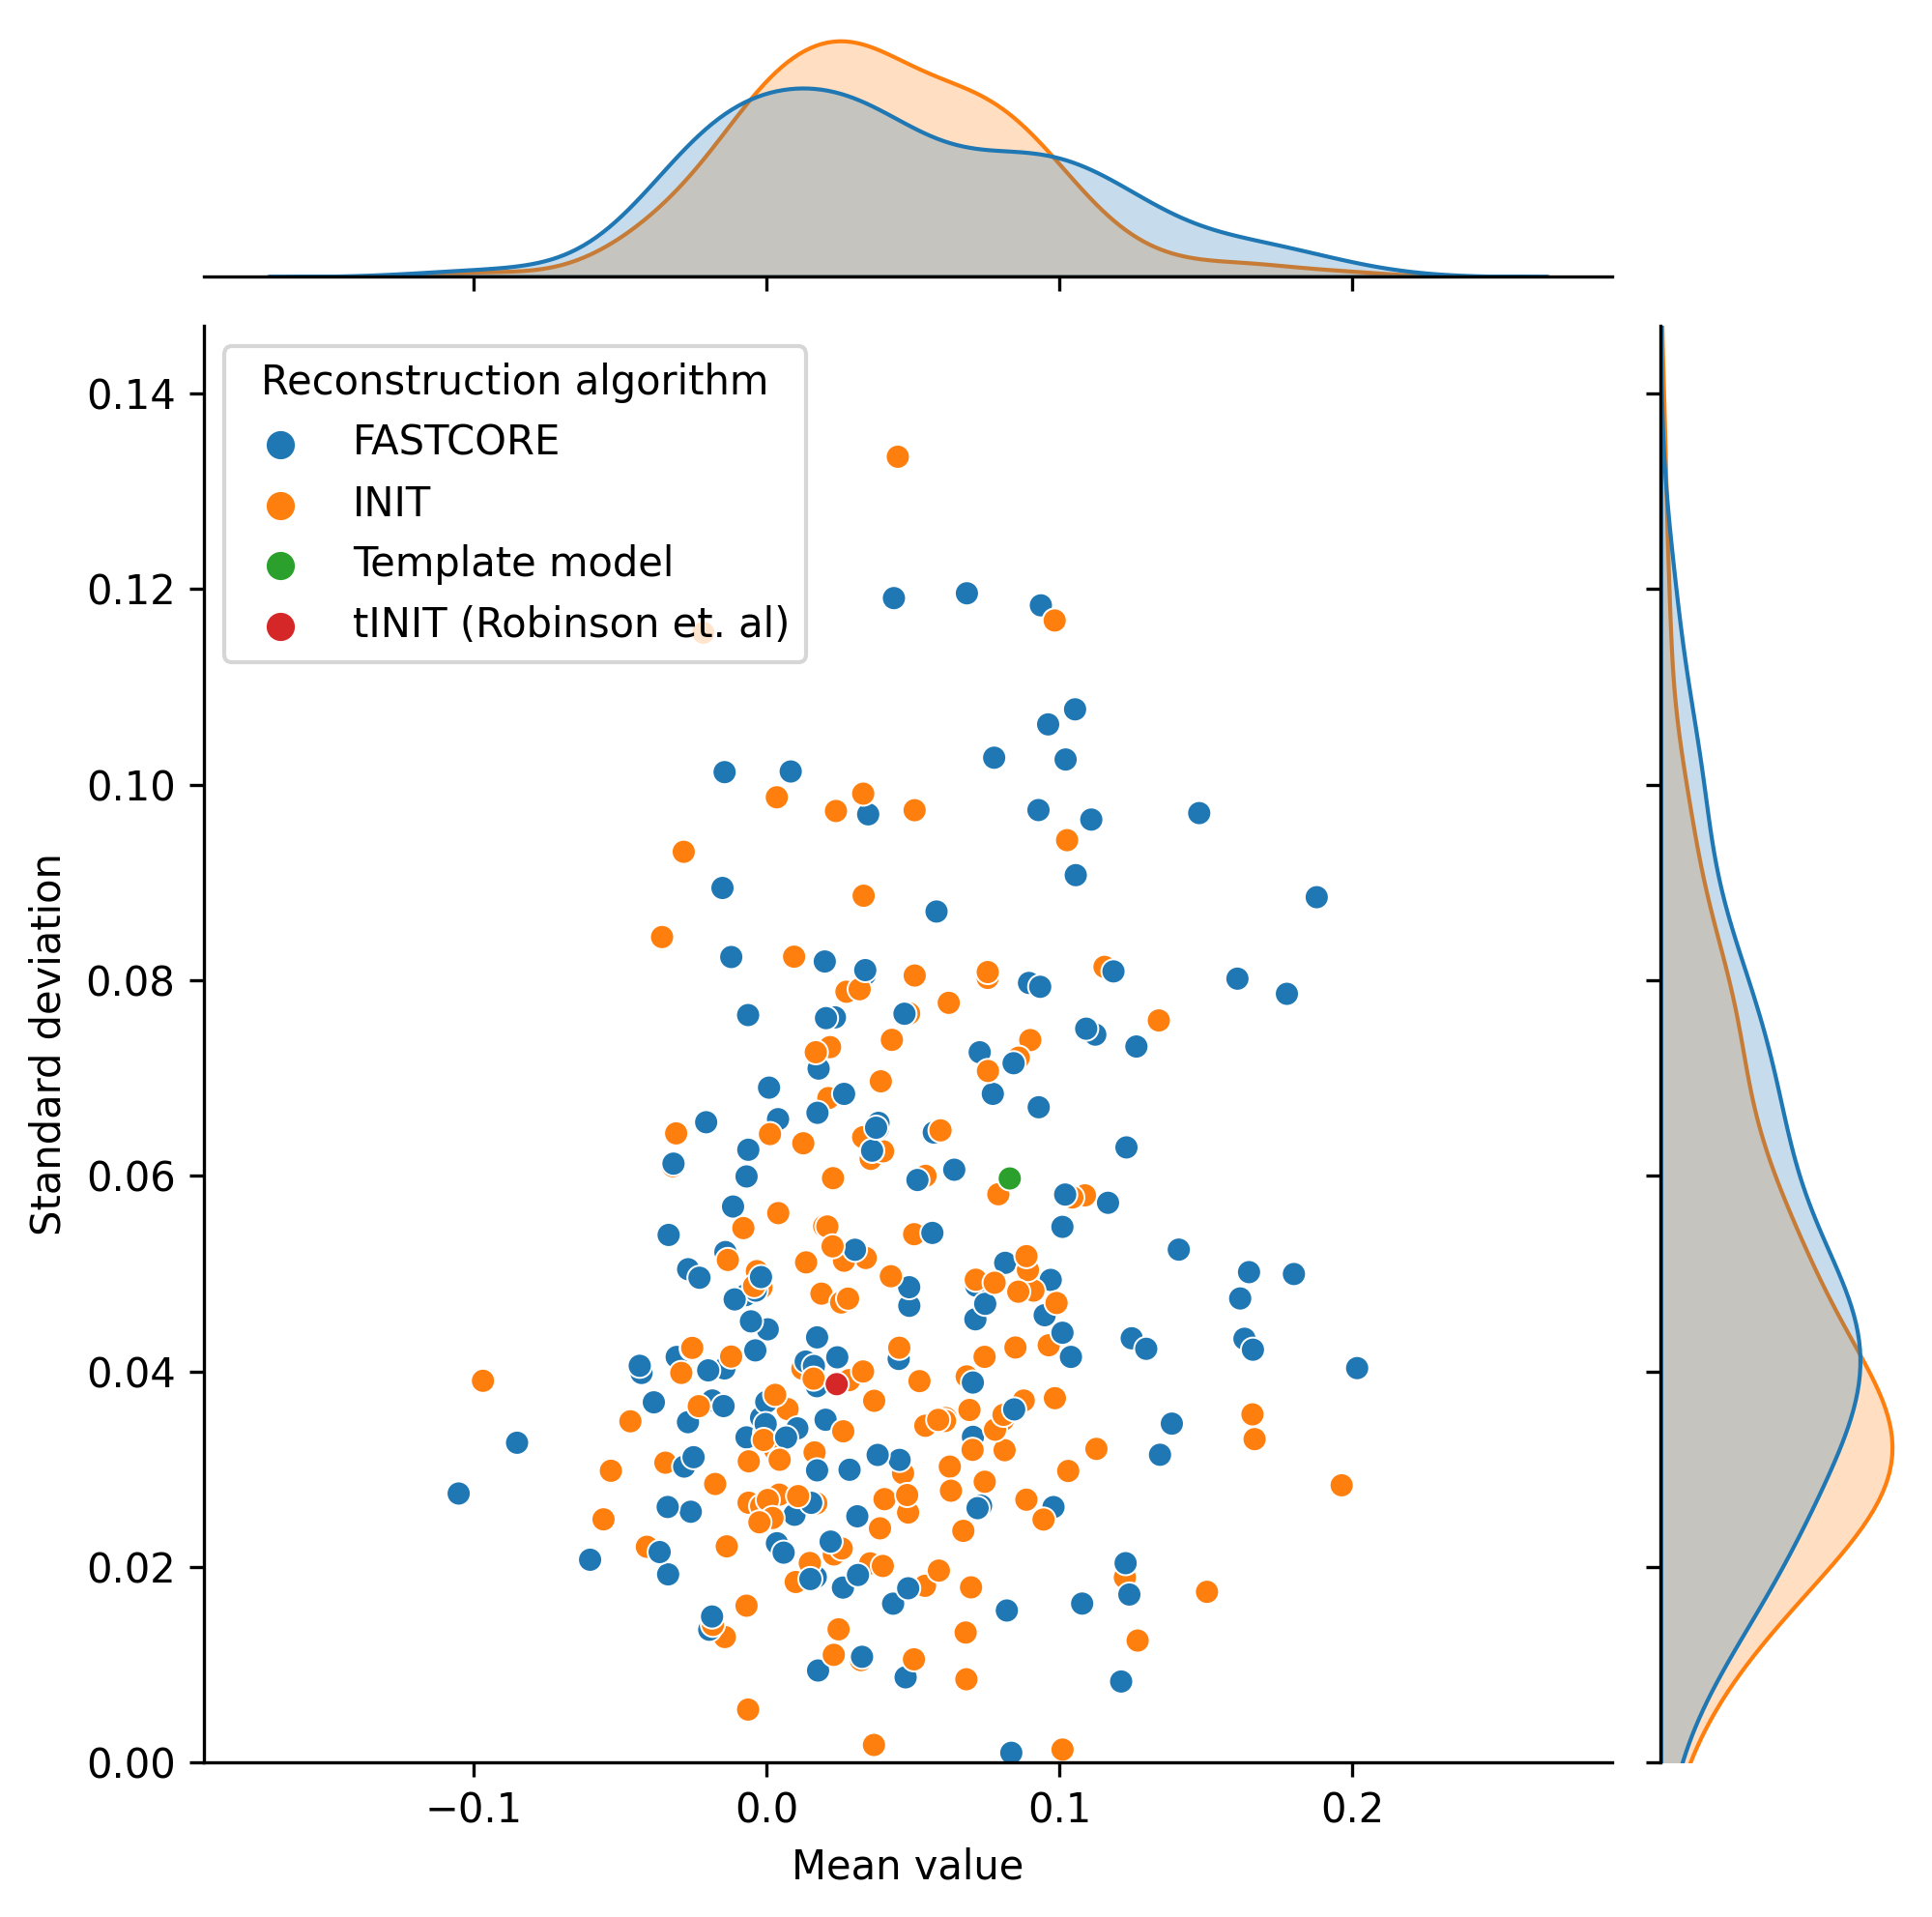

In [263]:
jp_data = sign_agreement_mean_df.query('media_bounds != "bounded" ').rename(columns=pretty_names).replace(pretty_names)
g = sns.jointplot(x=pretty_names['value_mean'],y=pretty_names['value_sd'], hue=pretty_names['algorithm'], data=jp_data,
             height=5)
g.fig.set_dpi(300)
g.fig.set_size_inches(7, 7)
sd_max = jp_data['Standard deviation'].max()
scl_v = 0.1
g.fig.axes[0].set_ylim(0, sd_max*(1+scl_v))
plt.savefig('projects/breast_mcf7/notebooks/mcf7_params_flux_density.pdf')

In [235]:
dfs = []
pred_cols = ['value_mean','value_sd']
pred_var = 'value_mean'
for algorithm in ['tinit','fastcore']:
    
    data_orig_all = sign_agreement_mean_df.query('algorithm == "'+algorithm+'"').drop(columns='algorithm')
    y = data_orig_all[pred_var]
    data_orig = data_orig_all.astype(str).drop(columns=pred_cols)\
                .rename(columns=pretty_names).replace(pretty_names)
    
    clf = Pipeline([('encode', OneHotEncoder()), ('lr', LinearRegression())])
    clf.fit(data_orig, y)

    lreg = clf.steps[-1][1]

    feature_names = [data_orig.columns[int(i[0][1])] + ' = ' + '_'.join(i[1:]) 
     for i in [k.split('_') for k in clf.steps[-2][1].get_feature_names()]]

    var_importance = pd.DataFrame({'name': feature_names, pretty_names[algorithm]: lreg.coef_, 
                                   'abs_importance_'+pretty_names[algorithm]: npabs(lreg.coef_)})
    dfs.append(var_importance)
    

In [246]:
var_imp_merge = pd.merge(*dfs)
var_imp_merge = var_imp_merge.loc[:,filter(lambda x: not x.startswith('abs_'), var_imp_merge.columns)]
var_importance_df = pd.melt(var_imp_merge, id_vars=['name'])

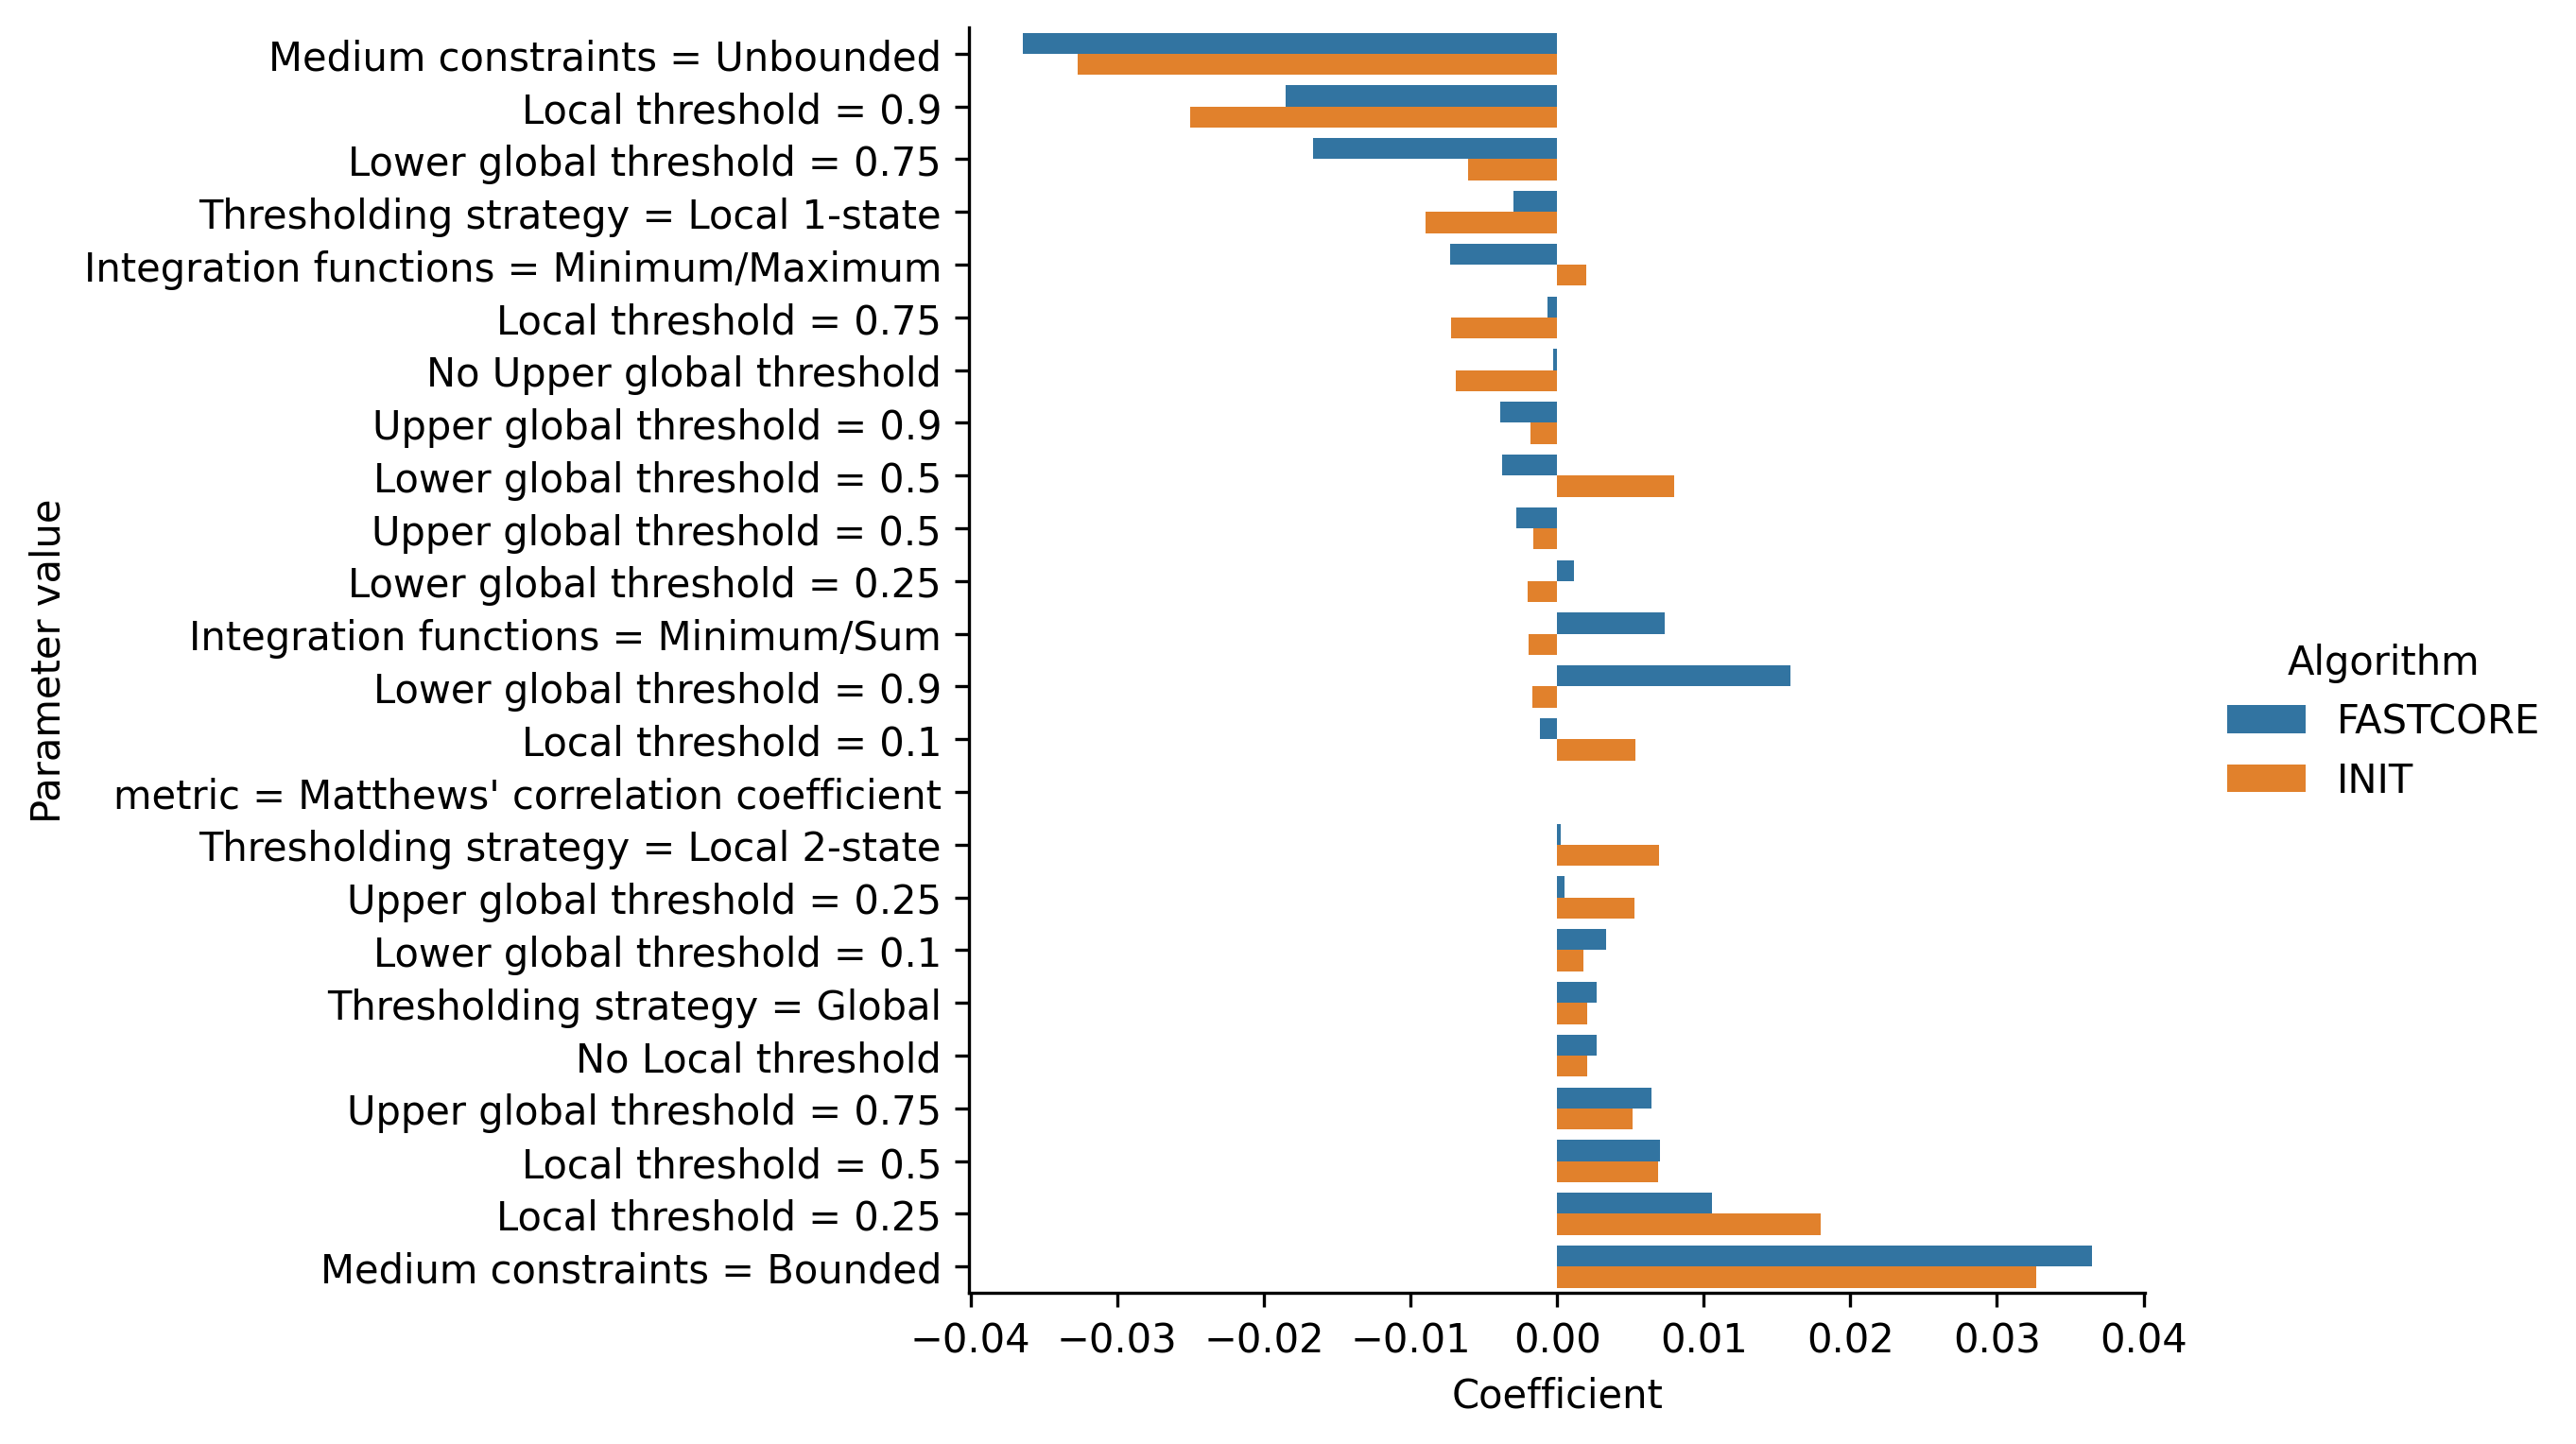

In [264]:
cp_data = var_importance_df.sort_values(by='value')
cp_data.columns = ['Parameter value', 'Algorithm', 'Coefficient']
pvs = cp_data['Parameter value']
cp_data['Parameter value'] = pvs.apply(lambda x: 'No '+x.split(' = ')[0] if x.endswith('-') else x)

g = sns.catplot(data=cp_data, x='Coefficient',y='Parameter value',hue='Algorithm', kind='bar', 
            height=5, aspect=1.5)
g.fig.set_size_inches(10, 5)
g.fig.set_dpi(300)
plt.savefig('projects/breast_mcf7/notebooks/mcf7_flux_params_coefficients.pdf')

In [62]:
ub_perf, bo_perf = [sign_agreement_df.query('media_bounds == "'+condition+'"').\
            groupby(list(filter(lambda x: x not in ['exp_condition', 'metric','value'],sign_agreement_df.columns))).\
            mean().sort_values(by='value',ascending=False) for condition in ['bounded','unbounded']]